
📥 Loading CTU-42 Dataset...

🧠 Training CTU malware classifier...

🎯 CTU Classifier Results:
Accuracy: 0.9959979989994997
[[1979    2]
 [   6   12]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1981
        True       0.86      0.67      0.75        18

    accuracy                           1.00      1999
   macro avg       0.93      0.83      0.87      1999
weighted avg       1.00      1.00      1.00      1999

✅ CTU malware model saved.

📊 Clustering IoT devices...
✅ IoT clustering completed.

📡 Streaming WLS data (first 50,000 lines)...
✅ Loaded WLS sample of shape: (50000, 21)

🧠 Visualizing IoT clusters with PCA...


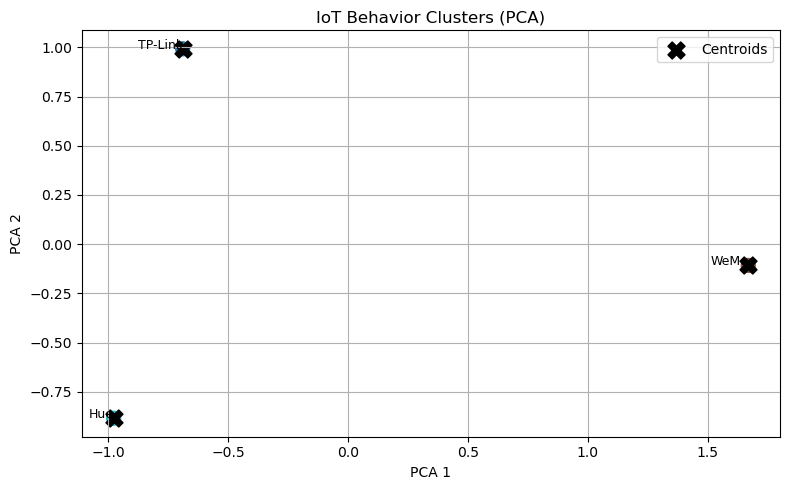


✅ Models saved to 'models/'
📬 Clustered IoT data saved to 'output/iot_clustered.csv'


In [20]:
# NetWatch_Realdata_models.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib
import json
import os

# === 1. LOAD + CLEAN REAL DATA ===

print("\n📥 Loading CTU-42 Dataset...")
df_ctu = pd.read_csv("Real_data/ctu_malware_dataset/capture20110810.binetflow.txt", skipinitialspace=True)
df_ctu = df_ctu.dropna(subset=["TotBytes", "TotPkts", "Dur", "Label"])
df_ctu = df_ctu[df_ctu["TotBytes"] < 1e7]
df_ctu["is_malicious"] = ~df_ctu["Label"].str.contains("Background", case=False)
df_ctu["SrcBytes"] = pd.to_numeric(df_ctu["SrcBytes"], errors='coerce')
df_ctu["DstBytes"] = df_ctu["TotBytes"] - df_ctu["SrcBytes"]
df_ctu["Proto"] = df_ctu["Proto"].astype('category').cat.codes
df_ctu.dropna(subset=["SrcBytes", "DstBytes", "Proto"], inplace=True)
features_ctu = ["TotBytes", "TotPkts", "Dur", "SrcBytes", "DstBytes", "Proto"]
X_ctu = df_ctu[features_ctu]
y_ctu = df_ctu["is_malicious"]

# === 2. CTU MODEL TRAINING ===

print("\n🧠 Training CTU malware classifier...")
X_train, X_test, y_train, y_test = train_test_split(X_ctu, y_ctu, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\n🎯 CTU Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save CTU model
os.makedirs("models", exist_ok=True)
joblib.dump(clf, "models/ctu_malware_model.pkl")
print("✅ CTU malware model saved.")

# === 3. IoT Sentinel Dataset ===
iot_base_path = "Real_data/"
df_tp = pd.read_csv(os.path.join(iot_base_path, "tp_link_setup1.csv"))
df_hue = pd.read_csv(os.path.join(iot_base_path, "hue_setup1.csv"))
df_wemo = pd.read_csv(os.path.join(iot_base_path, "wemo_setup1.csv"))
for df in [df_tp, df_hue, df_wemo]:
    df.columns = ["time", "src_ip", "dst_ip", "frame_len", "proto"]
    df["frame_len"] = pd.to_numeric(df["frame_len"], errors="coerce")
    df.dropna(inplace=True)
    
# Inject minor variation into frame lengths for testing/demo
df_tp["frame_len"] += np.random.randint(0, 10, size=len(df_tp))
df_hue["frame_len"] += np.random.randint(10, 20, size=len(df_hue))
df_wemo["frame_len"] += np.random.randint(20, 30, size=len(df_wemo))

df_tp["device"] = "TP-Link"
df_hue["device"] = "Hue"
df_wemo["device"] = "WeMo"
df_iot = pd.concat([df_tp, df_hue, df_wemo], ignore_index=True)

# Cluster
print("\n📊 Clustering IoT devices...")
iot_features = df_iot.groupby("device")["frame_len"].agg(["mean", "std"]).reset_index()
scaler = StandardScaler()
iot_scaled = scaler.fit_transform(iot_features[["mean", "std"]])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
iot_features["cluster"] = kmeans.fit_predict(iot_scaled)
df_iot = df_iot.merge(iot_features[["device", "cluster"]], on="device", how="left")

# Save clustered
os.makedirs("output", exist_ok=True)
df_iot.to_csv("output/iot_clustered.csv", index=False)
print("✅ IoT clustering completed.")

# === 4. WLS Data ===
print("\n📡 Streaming WLS data (first 50,000 lines)...")
wls_path = os.path.join(iot_base_path, "wls_day-01")
logs = []
with open(wls_path, "r") as f:
    for i, line in enumerate(f):
        if i >= 50000:
            break
        try:
            logs.append(json.loads(line.strip()))
        except:
            continue
df_wls = pd.DataFrame(logs)
print("✅ Loaded WLS sample of shape:", df_wls.shape)

# WLS Summary
top_processes = df_wls['ProcessName'].value_counts().reset_index()
top_processes.columns = ['ProcessName', 'Count']
top_hosts = df_wls['LogHost'].value_counts().reset_index()
top_hosts.columns = ['LogHost', 'EventCount']

# === 5. Optional: PCA visualization of clusters ===

print("\n🧠 Visualizing IoT clusters with PCA...")
if iot_scaled.shape[1] >= 2:
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(iot_scaled)
    plt.figure(figsize=(8,5))
    plt.scatter(pca_result[:,0], pca_result[:,1], c=iot_features["cluster"], cmap='tab10', s=100)
    centers = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=150, marker='X', label='Centroids')
    for i, row in iot_features.iterrows():
        plt.text(pca_result[i,0], pca_result[i,1], row["device"], fontsize=9, ha='right')
    plt.title("IoT Behavior Clusters (PCA)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Not enough dimensions for PCA plot.")

# === 6. Final Summary ===

print("\n✅ Models saved to 'models/'")
print("📬 Clustered IoT data saved to 'output/iot_clustered.csv'")


#### === 3. VISUALIZATIONS ===

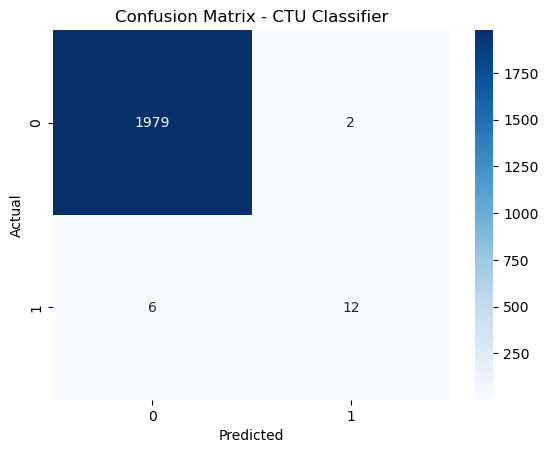

In [13]:
# Confusion Matrix Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CTU Classifier")
plt.show()

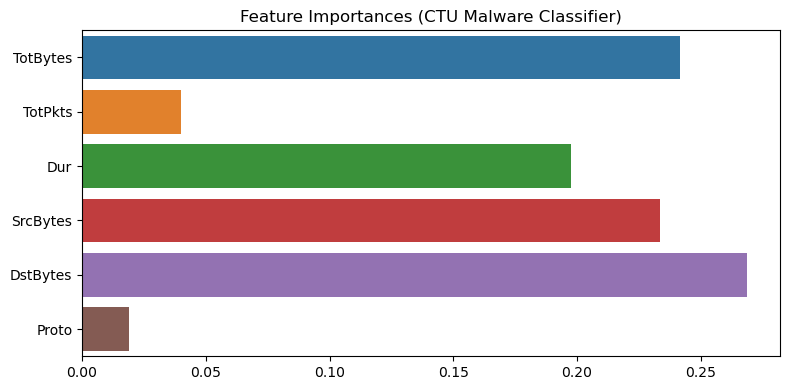

In [14]:
# Feature Importance
importances = clf.feature_importances_
feat_labels = X_ctu.columns
plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feat_labels)
plt.title("Feature Importances (CTU Malware Classifier)")
plt.tight_layout()
plt.show()


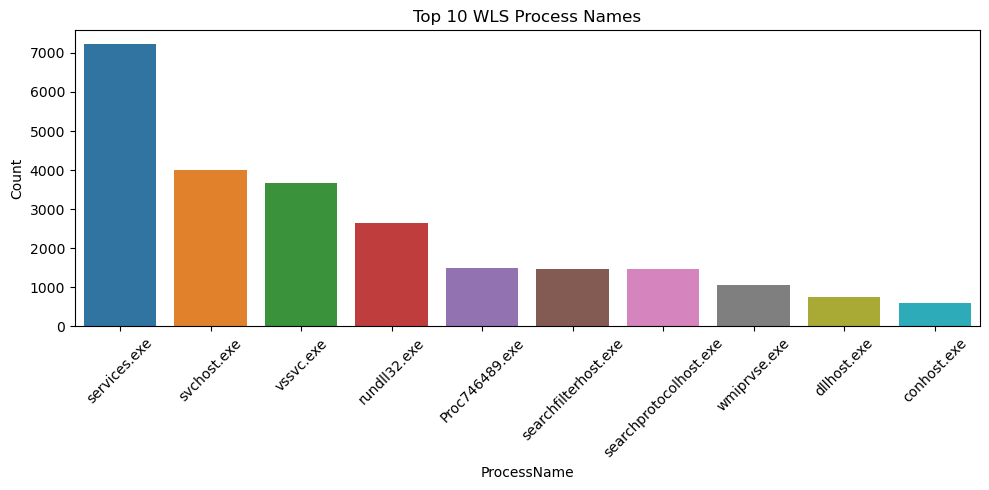

In [15]:
# WLS Process Chart
plt.figure(figsize=(10,5))
sns.barplot(data=top_processes.head(10), x="ProcessName", y="Count")
plt.title("Top 10 WLS Process Names")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

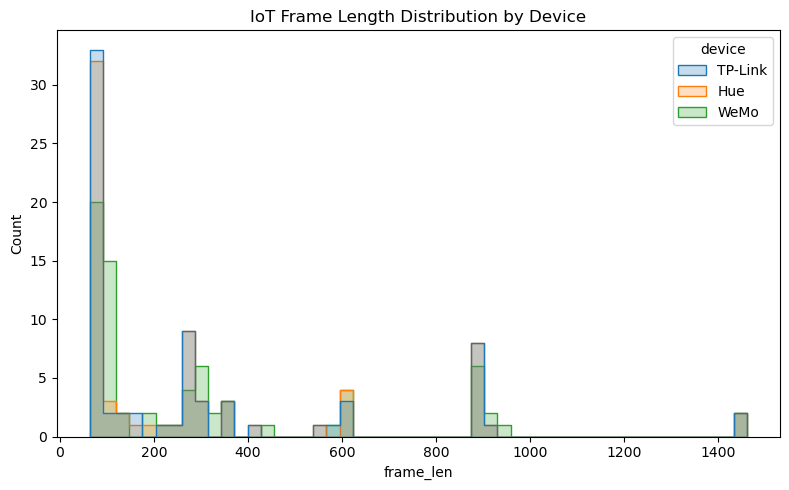

In [16]:
# IoT Device Distributions
plt.figure(figsize=(8,5))
sns.histplot(data=df_iot, x="frame_len", hue="device", bins=50, element="step")
plt.title("IoT Frame Length Distribution by Device")
plt.tight_layout()
plt.show()

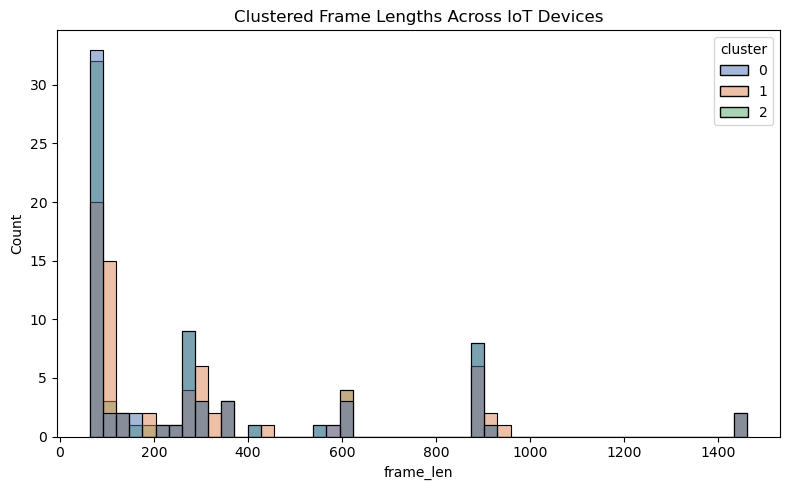

In [17]:
# IoT Cluster Distributions
plt.figure(figsize=(8,5))
sns.histplot(data=df_iot, x="frame_len", hue="cluster", bins=50, palette="deep")
plt.title("Clustered Frame Lengths Across IoT Devices")
plt.tight_layout()
plt.show()

In [18]:
# IoT Cluster Summary Table
iot_summary = df_iot.groupby(['device', 'cluster'])["frame_len"].agg(['count', 'mean', 'std']).reset_index()
print(iot_summary)

    device  cluster  count        mean         std
0      Hue        2     73  312.260274  333.870943
1  TP-Link        0     73  303.095890  334.079048
2     WeMo        1     73  322.547945  333.905635


/var/folders/fq/g897wng54x73hj9ss__c8p7c0000gn/T/ipykernel_75310/2807143720.py:13: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from current font.
  plt.tight_layout()
/Users/keerthichowdarygogineni/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


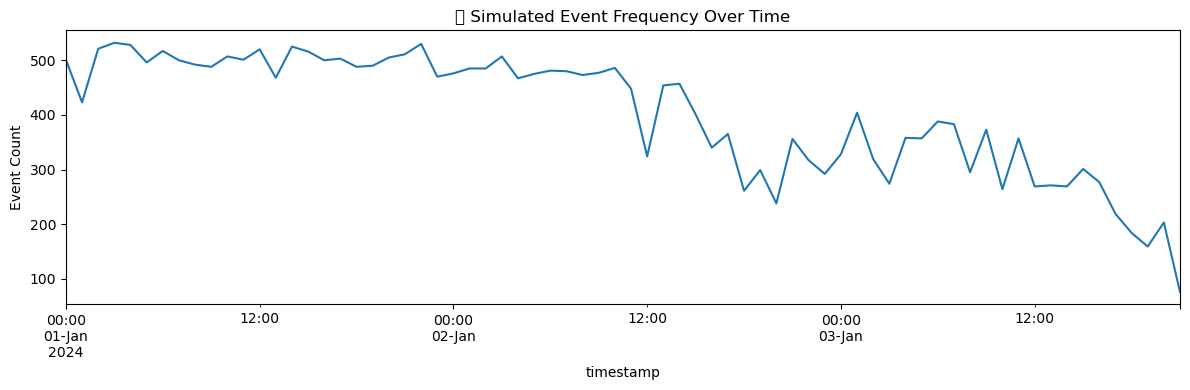

In [19]:
# === Optional: Simulated Timestamp Plotting (WLS) ===
# Since WLS logs lack real timestamps, simulate one for hourly trend visual

import datetime

base_time = pd.Timestamp("2024-01-01 00:00:00")
df_wls['timestamp'] = [base_time + pd.Timedelta(seconds=i*5) for i in range(len(df_wls))]

df_wls.set_index('timestamp', inplace=True)

df_wls['ProcessName'].resample('1H').count().plot(figsize=(12, 4), title='🕒 Simulated Event Frequency Over Time')
plt.ylabel("Event Count")
plt.tight_layout()
plt.show()
